<a href="https://colab.research.google.com/github/criegs/ML_Projects/blob/main/Connor_Riegal_ML_in_HC_2024_Heart_Failure_Classification_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable model for predicting death from heart failure

We will use a gradient boosted machine learning model, LightGBM, to predict heart failure. Read more about LightGBM here https://towardsdatascience.com/a-quick-guide-to-lightgbm-library-ef5385db8d10

### Note
For your project, make sure to make a copy of this project and do not edit directly on this copy

## Importing libraries

Run the below cell to import the tools we will be using for this project.

In [ ]:
!pip install aequitas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Added
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Exploratory analysis

------------------------------------------
The dataset loaded up for you, just run the below two cells:

In [ ]:
!git clone https://github.com/mnagy1716/ML-in-Health-Care/

Cloning into 'ML-in-Health-Care'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 31 (delta 7), reused 28 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 913.85 KiB | 6.05 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
data = pd.read_csv('./ML-in-Health-Care/data/Project_2/Heart Failure.csv')

### Data Exploration

#### TO DO

In [ ]:
# Explore the first 10 rows of the data
data.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes_status,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,No_Diabetes,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,No_Diabetes,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,No_Diabetes,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,Pre_Diabetes,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,Diabetes,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,No_Diabetes,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,No_Diabetes,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,Diabetes,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,Pre_Diabetes,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,No_Diabetes,35,1,388000.00,9.4,133,1,1,10,1


In [ ]:
# Check if there are any missing values in your dataset. Be aware, some data sets may label their missing values with another value (such as 99). Make sure to know your data before beginning your analysis
data.info()
# There are 299 non-null variables for each category of either float, integer, or object



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes_status           299 non-null    object 
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 30.5+ KB


In [ ]:
# Calculate the count of Heart Failure and Non-Heart Failure cases. Use .value_counts() methods in pandas dataframe. You will notice the target column "diagnosis" has two keys {'0': survived, 'B': dead}. Are the data balanced or no?
counts = data['DEATH_EVENT'].value_counts()
print(counts)

# Determine if the counts are balanced
if counts[0] == counts[1]:
  print("Data is balanced")
else:
  print("Data is imbalanced")


# Count the number of patients with ejection fraction less than 41
heart_failure_count = len(data[data['ejection_fraction'] < 41])

# Count the number of patients with ejection fraction greater than 40
non_heart_failure_count = len(data[data['ejection_fraction'] > 40])
print("Number of patients with heart failure (ejection fraction < 40):", heart_failure_count)
print("Number of patients without heart failure (ejection fraction > 40):", non_heart_failure_count)

# Determine if the counts are balanced
if heart_failure_count == non_heart_failure_count:
  print("Data is balanced")
else:
  print("Data is imbalanced")

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64
Data is imbalanced
Number of patients with heart failure (ejection fraction < 40): 219
Number of patients without heart failure (ejection fraction > 40): 80
Data is imbalanced


In [ ]:
#Print the data types of each of your features
types = data.dtypes
print(types)

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes_status              object
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


# First impressions:

1. What is our target variable?
> Our target variable is DEATH_EVENT
2. Is our data balanced?  If not which way is it skewed?
> The data is imbalanced and skewed towards patients who survived and patients with heart failure
2. What classes are our input data?
> Our data is in the form of float, int, and object
3. How many missing entries doe we have?
> None

## Data visualisation and pre-processing


#### TO DO
Assess data distribution of columns age, smoking, ejection fraction, and high blood pressure

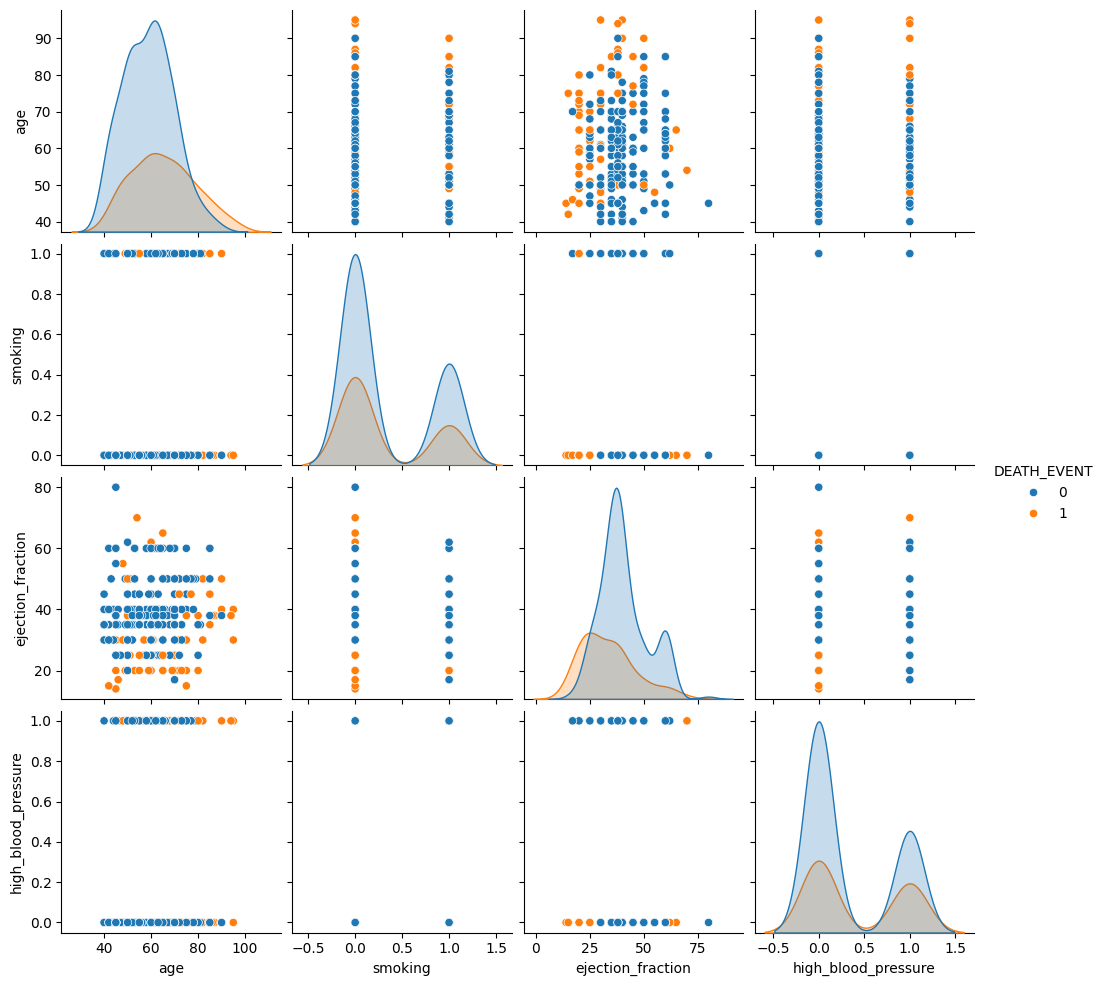

In [ ]:
# Create paired plot grid to evaluate data distribution across the input features [age, smoking, ejection fraction, and high blood pressure] and colored by the OUTCOME
# Check seaborn sns.PairGrid, for category separation you will need to use hue parameter.
# https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid
variables = ["age", "smoking", "ejection_fraction", "high_blood_pressure"]
sns.pairplot(data, hue='DEATH_EVENT', vars=variables)



Looking at your visualizations, What seems to be the relationship between ejection fraction, high blood pressure, and Death?

END TO DO

## Data Preprocessing

TO DO

In [ ]:
# Remove the Time Column from the data set
data = data.drop(columns=['time'])

In [ ]:
# Make diabetes_status into a dummy variable and drop original diabetes status variable
# How to avoid the dummy variable trap here?
get_dummies = pd.get_dummies(data['diabetes_status'])
data = pd.concat([data, get_dummies], axis=1)
data = data.drop(columns=['diabetes_status'])

data.head(10)

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT,Diabetes,No_Diabetes,Pre_Diabetes
0,75.0,0,582,20,1,265000.00,1.9,130,1,0,1,False,True,False
1,55.0,0,7861,38,0,263358.03,1.1,136,1,0,1,False,True,False
2,65.0,0,146,20,0,162000.00,1.3,129,1,1,1,False,True,False
3,50.0,1,111,20,0,210000.00,1.9,137,1,0,1,False,False,True
4,65.0,1,160,20,0,327000.00,2.7,116,0,0,1,True,False,False
5,90.0,1,47,40,1,204000.00,2.1,132,1,1,1,False,True,False
6,75.0,1,246,15,0,127000.00,1.2,137,1,0,1,False,True,False
7,60.0,1,315,60,0,454000.00,1.1,131,1,1,1,True,False,False
8,65.0,0,157,65,0,263358.03,1.5,138,0,0,1,False,False,True
9,80.0,1,123,35,1,388000.00,9.4,133,1,1,1,False,True,False


In [ ]:
#Make all input features X and the outcome feature Y
X = data[[
          'age',
          'sex',
          'creatinine_phosphokinase',
          'ejection_fraction',
          'smoking',
          'anaemia',
          'high_blood_pressure',
          'platelets',
          'serum_creatinine',
          'serum_sodium',
          'Diabetes',
          'No_Diabetes',
          'Pre_Diabetes',
]]
y = data['DEATH_EVENT']


### Train Test Split


In [ ]:
#Split the data into 70% training set and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y ,random_state=1)

END TO DO

## Modeling
--------------------------------------
Import LightGBM classifier


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMModel
from lightgbm import LGBMClassifier

### TO DO

In [ ]:
#Train the Light GBM model
# Consider using scikit learn grid search

# Train data
train_data = lgb.Dataset(X_train, label=y_train)
# Test data
test_data = lgb.Dataset(X_test, label=y_test)

# Parameters - ***This is something I am struggling to understand
params = {
    'objective': 'binary',  # For binary classification
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Adjust as needed
    'learning_rate': 0.05,  # Adjust as needed
    'feature_fraction': 0.9,  # Adjust as needed
}

# Train the GBM
# *** Should I use an early stopping feature?
model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 67, number of negative: 142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 209, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320574 -> initscore=-0.751134
[LightGBM] [Info] Start training from score -0.751134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
#Predict the outcome for train and test set
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]  # Convert probabilities to binary predictions

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Print the outcome predictions
print("\nOutcome Predictions:")
for i in range(len(y_pred_binary)):
    print(f"Patient {i+1}: Predicted Outcome - {y_pred_binary[i]}")



Accuracy: 0.7

Outcome Predictions:
Patient 1: Predicted Outcome - 0
Patient 2: Predicted Outcome - 0
Patient 3: Predicted Outcome - 0
Patient 4: Predicted Outcome - 1
Patient 5: Predicted Outcome - 0
Patient 6: Predicted Outcome - 0
Patient 7: Predicted Outcome - 1
Patient 8: Predicted Outcome - 0
Patient 9: Predicted Outcome - 1
Patient 10: Predicted Outcome - 0
Patient 11: Predicted Outcome - 0
Patient 12: Predicted Outcome - 0
Patient 13: Predicted Outcome - 0
Patient 14: Predicted Outcome - 0
Patient 15: Predicted Outcome - 0
Patient 16: Predicted Outcome - 0
Patient 17: Predicted Outcome - 0
Patient 18: Predicted Outcome - 0
Patient 19: Predicted Outcome - 0
Patient 20: Predicted Outcome - 1
Patient 21: Predicted Outcome - 1
Patient 22: Predicted Outcome - 0
Patient 23: Predicted Outcome - 0
Patient 24: Predicted Outcome - 0
Patient 25: Predicted Outcome - 0
Patient 26: Predicted Outcome - 0
Patient 27: Predicted Outcome - 0
Patient 28: Predicted Outcome - 0
Patient 29: Predicted

In [ ]:
#Print AUROC for the training and test data
print("AUROC for the training data: ", roc_auc_score(y_train, model.predict(X_train)))
print("AUROC for the test data: ", roc_auc_score(y_test, model.predict(X_test)))

AUROC for the training data:  0.9882278747109523
AUROC for the test data:  0.6941775014132279


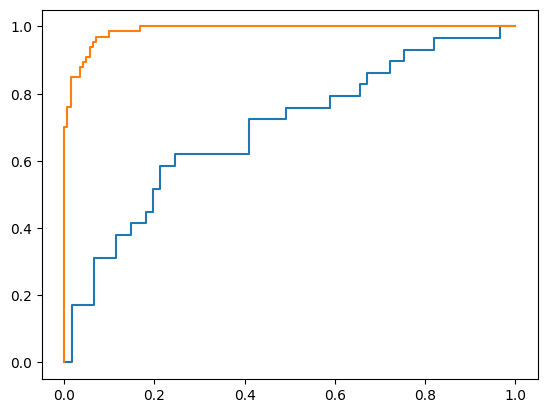

In [ ]:
#Graph ROC Curve for the Train and Test set
# How to improve the data and understanding of the problem, the model may not be the problem. As a physician with understanding of the dx, define the model and problem in the best.
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Test Set')
fpr, tpr, thresholds = roc_curve(y_train, model.predict(X_train))
plt.plot(fpr, tpr, label='Train Set')



## Interpretibility

### SHAP: SHapley Additive exPlanations

In [ ]:
%%capture
!pip install shap

In [ ]:
import shap

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Variable Importance by SHAP for DEATH_EVENT


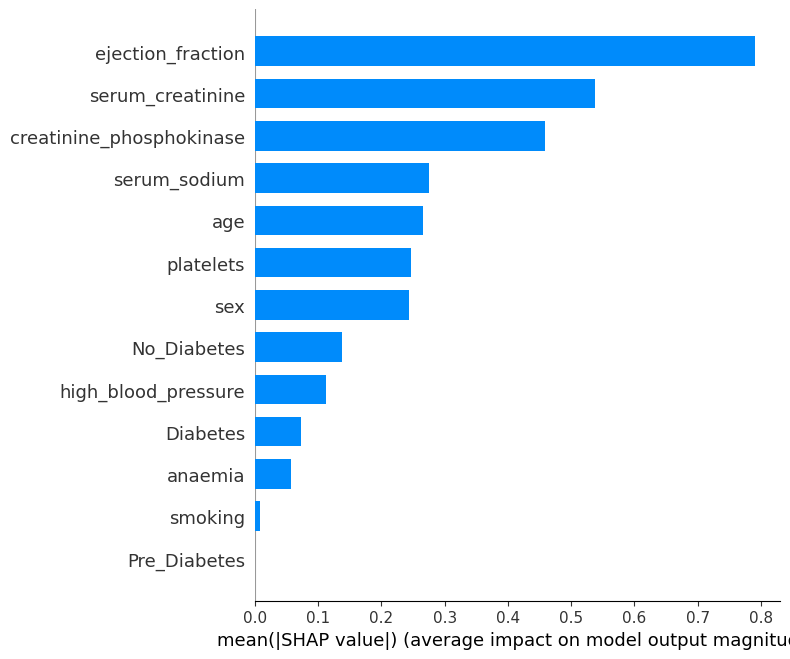

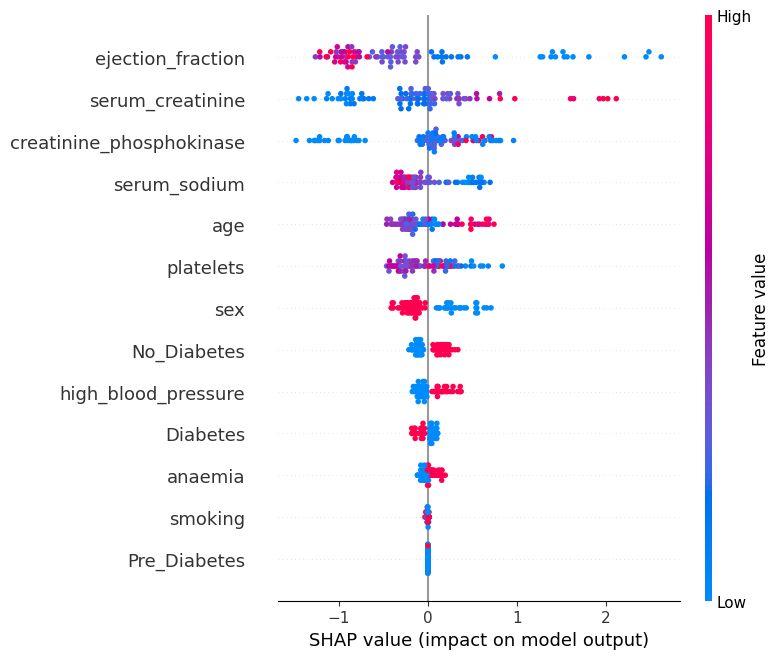

In [ ]:
# Print a shap summary plot and a shap bar plot (see lecture 5)
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(X_test)
print ('Variable Importance by SHAP for DEATH_EVENT')
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test, show=True)

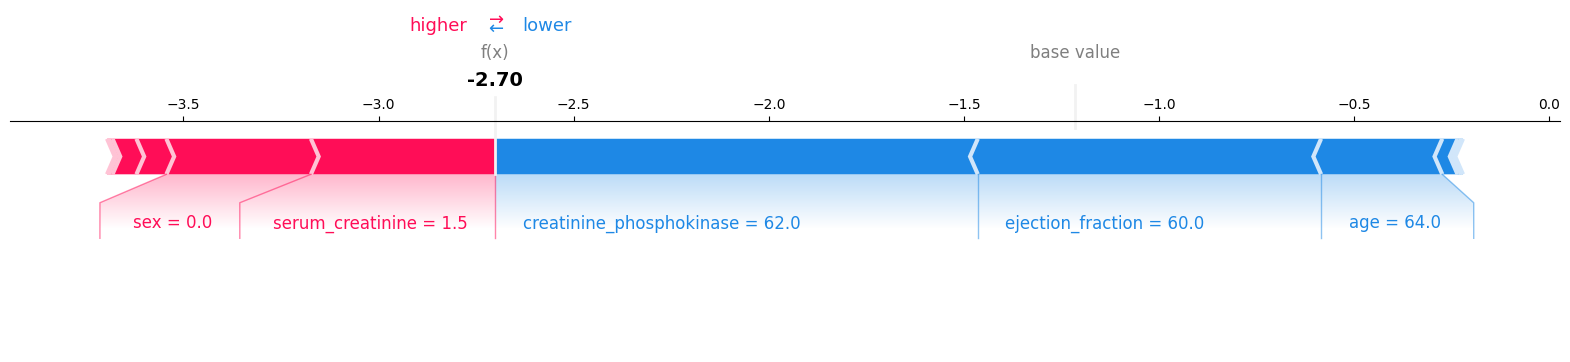

In [ ]:
#Show the individual shap force plot for any of the female patients above the age of 60 (Lecture 5)

# Index female & >60 data points and create subset
female_above_60_indices = X_test[(X_test['sex'] == 0) & (X_test['age'] > 60)].index
X_test_subset = X_test[X_test.index.isin(female_above_60_indices)]

# Select the SHAP values for the desired patients using the filtered subset's index
shap_values_subset = shap_values[X_test.index.get_indexer(X_test_subset.index)]

# Display the SHAP force plot for the first patient in the subset
if len(shap_values_subset) > 0:
    shap.force_plot(explainer.expected_value, shap_values_subset[0], X_test_subset.iloc[0], show=True, matplotlib=True)
else:
    print("No female patients above 60 found in the test set.")



## Fairness

### Using Aequitas library Lecture 15

In [ ]:
%%capture
!pip install aequitas==0.4.1

In [ ]:
from aequitas.bias import Bias
from aequitas.group import Group
from aequitas.plotting import Plot
import aequitas.plot as ap


In [ ]:
#Make outcomes table with the following columns ('score', 'label_value', 'sex')
fairness_df = pd.DataFrame({'score': model.predict(X_test),
                            'label_value': y_test.values.flatten(),
                            'sex': X_test['sex'].values.flatten()
                           })

#Convert Sex to str and score/label value to int
fairness_df['score'] = fairness_df['score'].astype('int')
fairness_df['label_value'] = fairness_df['label_value'].astype('int')
fairness_df['sex'] = fairness_df['sex'].astype('str')


In [ ]:
g = Group()
xtab, _ = g.get_crosstabs(fairness_df)

b = Bias()
bdf = b.get_disparity_predefined_groups(xtab,
                    original_df=fairness_df,
                    ref_groups_dict={'sex':'1'},
                    alpha=0.05,
                    check_significance=False)


metrics = ['fpr','fnr']
disparity_tolerance = 1.25

In [ ]:
# Check the relative and absolute disparity by sex of FPR and FNF for the outcome
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

gaf = f.get_group_attribute_fairness(fdf)
gaf


,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,sex,NaN,NaN,NaN,NaN,True,True,NaN,True,True,NaN,NaN,True,NaN,NaN,False


In [ ]:
# Show if your model has any bias for our chosen metrics based on the disparity threshold above of 1.25 (does is pass the parity test?)
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

Is there any bias in our outcome between male and female for FPR or FNR? What is it, and whwat implications might this have clinically?

>There is parity in regards to FNR. Based on the results, it seems like the model calculates false negatives (misses) equally between the two genders of male and female For FPR there were likely too few cases of False Positive results to calculate parity.
